# 加州房价预测分析 Analysis of California Housing Price Prediction
**GDUFE-cclear116-2025/5/12**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.feature_selection import SelectKBest, f_regression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
import warnings
import os
import joblib
warnings.filterwarnings('ignore')

# 设置中文字体
plt.rcParams["font.family"] = ["SimHei"]
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题


=== 数据概览 ===
   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY  

=== 描述性统计 ===
          longitude      latitude  housing_med

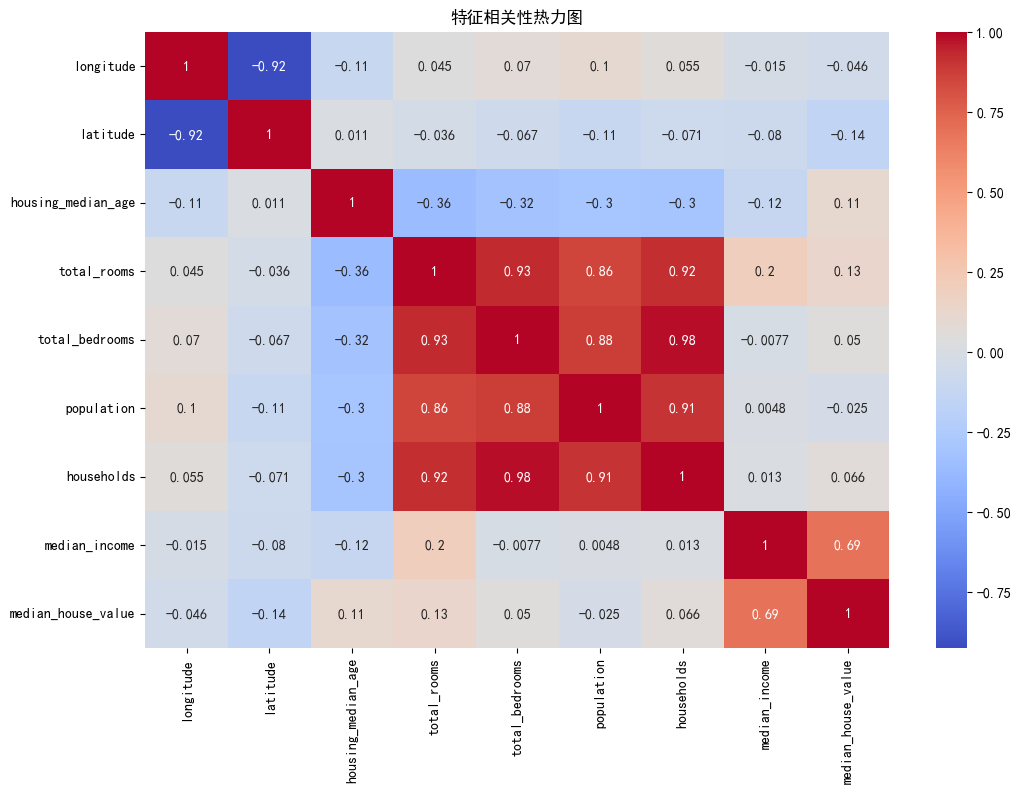

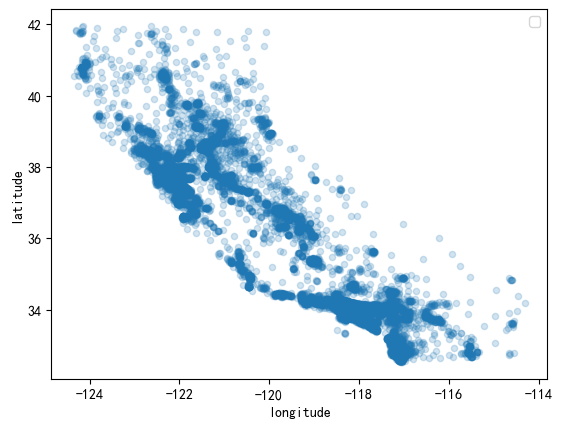

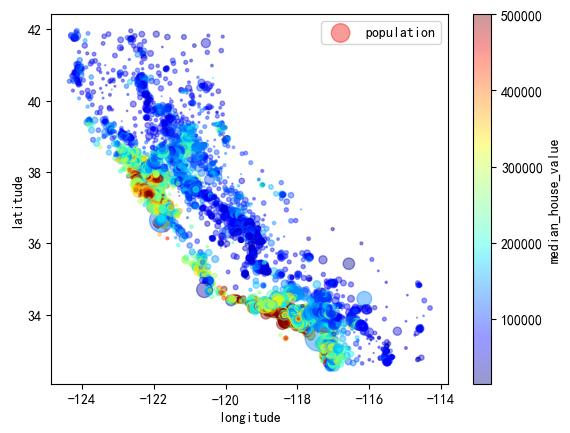

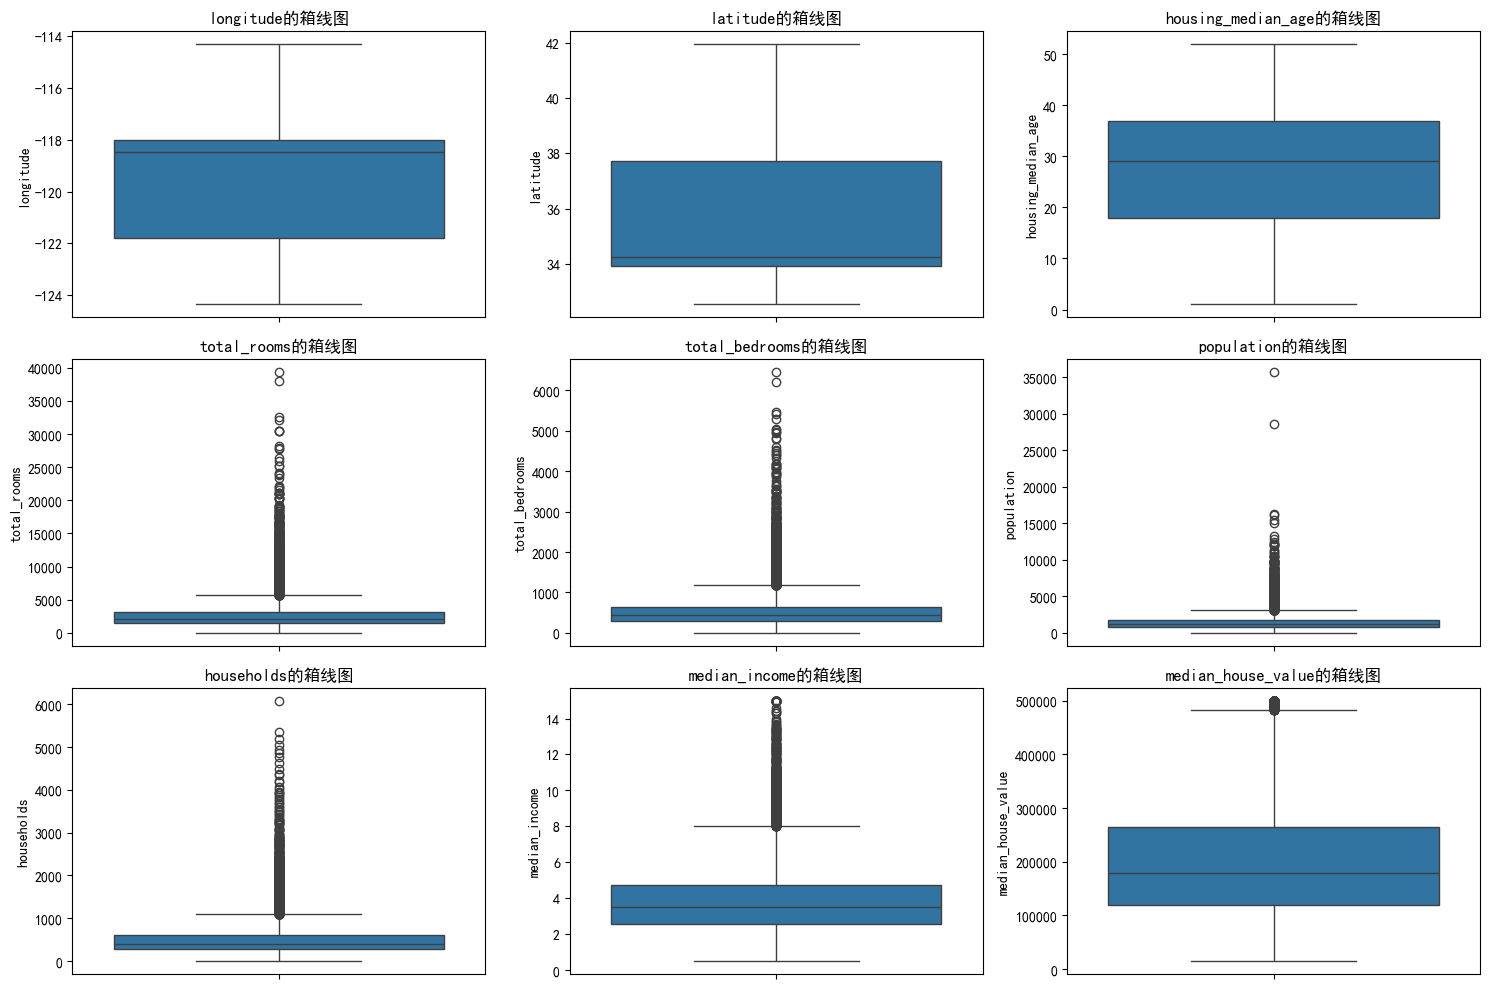


=== 缺失值处理 ===
缺失值统计:
total_bedrooms    207
dtype: int64

=== 异常值处理 ===
检测到3031个异常值样本，占比14.69%
去除异常值后，数据集从17609行减少到17609行


In [2]:
# ================== 1. 数据获取和加载 ==================
try:
    data = pd.read_csv("housing.csv")
except FileNotFoundError:
    # 如果本地文件不存在，尝试从sklearn加载
    from sklearn.datasets import fetch_california_housing
    housing = fetch_california_housing()
    data = pd.DataFrame(housing.data, columns=housing.feature_names)
    data['median_house_value'] = housing.target
    data.to_csv("housing.csv", index=False)

# ================== 2. 数据探索和清洗 ==================
print("\n=== 数据概览 ===")
print(data.head())

print("\n=== 描述性统计 ===")
print(data.describe())

# ocean_proximity这一列有不同的分类
print("\n查看ocean_proximity的所有分类：")
print(data['ocean_proximity'].value_counts())

# 相关性分析
data_temp = data.drop("ocean_proximity", axis=1)  # 去除非数值列
correlation_matrix = data_temp.corr()  # 计算相关系数矩阵
# print("相关系数矩阵：")
# print(correlation_matrix)
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')  # 传入相关系数矩阵
plt.title('特征相关性热力图')
plt.show()

data.plot(kind="scatter", x="longitude", y="latitude", alpha=0.2)
plt.legend()

data.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,s=data["population"]/100, label="population",c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend()

# 异常值可视化
def visualize_outliers(df, columns=None, figsize=(15, 10)):
    """可视化数据集中的异常值"""
    if columns is None:
        # 选择数值型列
        columns = df.select_dtypes(include=[np.number]).columns.tolist()
    
    num_cols = len(columns)
    rows = (num_cols + 2) // 3  # 每行显示3个图
    
    plt.figure(figsize=figsize)
    for i, col in enumerate(columns, 1):
        plt.subplot(rows, 3, i)
        sns.boxplot(y=df[col])
        plt.title(f'{col}的箱线图')
        plt.tight_layout()
    
    plt.show()

# 可视化原始数据的异常值
visualize_outliers(data)

# 缺失值处理
print("\n=== 缺失值处理 ===")
missing_values = data.isnull().sum()
print("缺失值统计:")
print(missing_values[missing_values > 0])

# 填充total_bedrooms的缺失值
median_bedrooms = data['total_bedrooms'].median()
data['total_bedrooms'] = data['total_bedrooms'].fillna(median_bedrooms)  # 修正警告（修正链式赋值警告）

# 异常值处理（使用IQR方法）
print("\n=== 异常值处理 ===")
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()

# 使用IQR方法检测异常值
Q1 = data[numeric_cols].quantile(0.25)
Q3 = data[numeric_cols].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = ((data[numeric_cols] < lower_bound) | (data[numeric_cols] > upper_bound)).any(axis=1)

print(f"检测到{outliers.sum()}个异常值样本，占比{outliers.mean()*100:.2f}%")
data = data[~outliers]
print(f"去除异常值后，数据集从{len(data)}行减少到{len(data)}行")

# 可视化处理后的异常值()
# visualize_outliers(data)


In [3]:
# ================== 3. 特征工程 ==================
print("\n=== 特征工程 ===")

# 对ocean_proximity进行独热编码
data = pd.get_dummies(data, columns=['ocean_proximity'], prefix=['proximity'])

# 添加交互项
data['rooms_per_household'] = data['total_rooms'] / data['households']
data['bedrooms_per_room'] = data['total_bedrooms'] / data['total_rooms']
data['population_per_household'] = data['population'] / data['households']

# 添加经纬度的多项式特征
data['longitude_squared'] = data['longitude'] ** 2
data['latitude_squared'] = data['latitude'] ** 2
data['longitude_latitude'] = data['longitude'] * data['latitude']

# ================== 4. 数据预处理 ==================
print("\n=== 数据预处理 ===")

# 2.1 定义特征与目标变量
X = data.drop('median_house_value', axis=1)
y = data['median_house_value']

# 2.2 分类特征编码与数值特征标准化
# 重新定义分类列和数值列
categorical_features = [col for col in X.columns if 'proximity' in col]
numerical_features = [col for col in X.columns if 'proximity' not in col]

test_size = 0.2
# 2.3 划分训练集和测试集（添加分层抽样）
if categorical_features:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=1234, 
        stratify=X[categorical_features[0]] if len(categorical_features) > 0 else None
    )
else:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=1234
    )

print(f"\n训练集样本数: {X_train.shape[0]}, 测试集样本数: {X_test.shape[0]}")

# 2.4 处理分类特征 - 独热编码（修正sparse参数）
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)  # 修正参数
X_train_cat = encoder.fit_transform(X_train[categorical_features])
X_test_cat = encoder.transform(X_test[categorical_features])

# 获取编码后的特征名称
cat_feature_names = encoder.get_feature_names_out(categorical_features)

# 2.5 处理数值特征 - 标准化
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train[numerical_features])
X_test_num = scaler.transform(X_test[numerical_features])

# 2.6 合并处理后的特征
X_train_processed = np.hstack([X_train_num, X_train_cat])
X_test_processed = np.hstack([X_test_num, X_test_cat])

# 创建完整的特征名称列表
feature_names = numerical_features + list(cat_feature_names)

# 转换为DataFrame以便后续分析
X_train_df = pd.DataFrame(X_train_processed, columns=feature_names)
X_test_df = pd.DataFrame(X_test_processed, columns=feature_names)



=== 特征工程 ===

=== 数据预处理 ===

训练集样本数: 14087, 测试集样本数: 3522


In [4]:
# ================== 5. 模型评估函数 ==================
def evaluate_model(model, X_train, X_test, y_train, y_test, cv=5):
    """模型评估函数，返回R²、调整R²、MSE、RMSE、MAE和交叉验证分数"""
    # 训练模型
    model.fit(X_train, y_train)
    
    # 在测试集上预测
    y_pred = model.predict(X_test)
    
    # 计算指标
    r2 = r2_score(y_test, y_pred)
    n, p = X_test.shape
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    
    # 交叉验证
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2')
    
    return {
        'R²': r2, 
        '调整R²': adj_r2, 
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        '交叉验证R²均值': cv_scores.mean(),
        '交叉验证R²标准差': cv_scores.std()
    }

# ================== 6. 模型保存与加载功能 ==================
def save_trained_models(models_dict, directory='saved_models'):
    """保存训练好的模型到指定目录"""
    # 创建保存目录（如果不存在）
    if not os.path.exists(directory):
        os.makedirs(directory)
        
    for name, model in models_dict.items():
        file_path = os.path.join(directory, f'{name}_model.pkl')
        joblib.dump(model, file_path)
        print(f"{name}模型已保存到: {file_path}")

def load_saved_model(model_name, directory='saved_models'):
    """从指定目录加载保存的模型"""
    file_path = os.path.join(directory, f'{model_name}_model.pkl')
    
    if os.path.exists(file_path):
        model = joblib.load(file_path)
        print(f"已加载{model_name}模型")
        return model
    else:
        print(f"错误: 找不到{model_name}模型文件: {file_path}")
        return None


In [5]:
# ================== 7. 正则化模型 ==================
print("\n=== 训练正则化模型 ===")

# 7.1 定义模型参数网格
param_grid = {
    'Lasso': {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]},
    'Ridge': {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]},
    'ElasticNet': {'alpha': [0.001, 0.01, 0.1, 1, 10, 100], 
                   'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]}
}

# 7.2 模型训练与参数优化
models = {
    'Lasso': Lasso(max_iter=10000),
    'Ridge': Ridge(),
    'ElasticNet': ElasticNet(max_iter=10000)
}

results = []
best_models = {}

# 检查是否已有保存的模型
use_saved_models = False  # 可以修改为True来尝试加载已保存的模型
if use_saved_models:
    print("\n=== 尝试加载已保存的模型 ===")
    for name in models.keys():
        model = load_saved_model(name)
        if model:
            best_models[name] = model
            metrics = evaluate_model(model, X_train_df, X_test_df, y_train, y_test)
            results.append({
                '模型': name,
                **metrics,
                '最佳参数': model.get_params()
            })
            print(f"{name}模型加载成功并评估完成")
        else:
            print(f"无法加载{name}模型，将重新训练")
            use_saved_models = False

# 如果没有保存的模型或选择重新训练
if not use_saved_models:
    print("\n=== 训练正则化模型 ===")
    for name, model in models.items():
        print(f"\n正在优化{name}模型...")
        
        # 网格搜索优化
        gs = GridSearchCV(
            model, 
            param_grid[name],
            cv=5,
            scoring='r2',
            n_jobs=-1,  # 使用所有CPU核心
            verbose=1
        )
        gs.fit(X_train_df, y_train)
        
        # 存储最佳模型
        best_models[name] = gs.best_estimator_
        
        # 评估性能
        metrics = evaluate_model(gs.best_estimator_, X_train_df, X_test_df, y_train, y_test)
        results.append({
            '模型': name,
            **metrics,
            '最佳参数': gs.best_params_
        })
        
        print(f"{name}模型优化完成，最佳参数: {gs.best_params_}")
    
    # 保存所有训练好的模型
    save_trained_models(best_models)

# 训练并评估线性回归模型
print("\n=== 训练多元线性回归模型 ===")
linear_model = LinearRegression()
linear_results = evaluate_model(linear_model, X_train_df, X_test_df, y_train, y_test)
results.append({
    '模型': '多元线性回归',
    **linear_results,
    '最佳参数': {}
})

# 保存线性回归模型
save_trained_models({'多元线性回归': linear_model})

# 结果对比
results_df = pd.DataFrame(results)
print("\n=== 模型性能对比 ===")
print(results_df[['模型', 'R²', '调整R²', 'MSE', 'RMSE', 'MAE', '交叉验证R²均值', '交叉验证R²标准差', '最佳参数']])



=== 训练正则化模型 ===

=== 训练正则化模型 ===

正在优化Lasso模型...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Lasso模型优化完成，最佳参数: {'alpha': 1}

正在优化Ridge模型...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Ridge模型优化完成，最佳参数: {'alpha': 0.001}

正在优化ElasticNet模型...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
ElasticNet模型优化完成，最佳参数: {'alpha': 0.001, 'l1_ratio': 0.9}
Lasso模型已保存到: saved_models\Lasso_model.pkl
Ridge模型已保存到: saved_models\Ridge_model.pkl
ElasticNet模型已保存到: saved_models\ElasticNet_model.pkl

=== 训练多元线性回归模型 ===
多元线性回归模型已保存到: saved_models\多元线性回归_model.pkl

=== 模型性能对比 ===
           模型        R²      调整R²           MSE          RMSE           MAE  \
0       Lasso  0.637214  0.634724  3.060393e+09  55320.820948  41527.273579   
1       Ridge  0.645957  0.643528  2.986638e+09  54650.137427  40649.930693   
2  ElasticNet  0.636988  0.634497  3.062301e+09  55338.057972  41527.980955   
3      多元线性回归  0.646100  0.643671  2.985435e+09  54639.135362  40626.751659 


=== 模型性能可视化对比 ===


<Figure size 640x480 with 0 Axes>

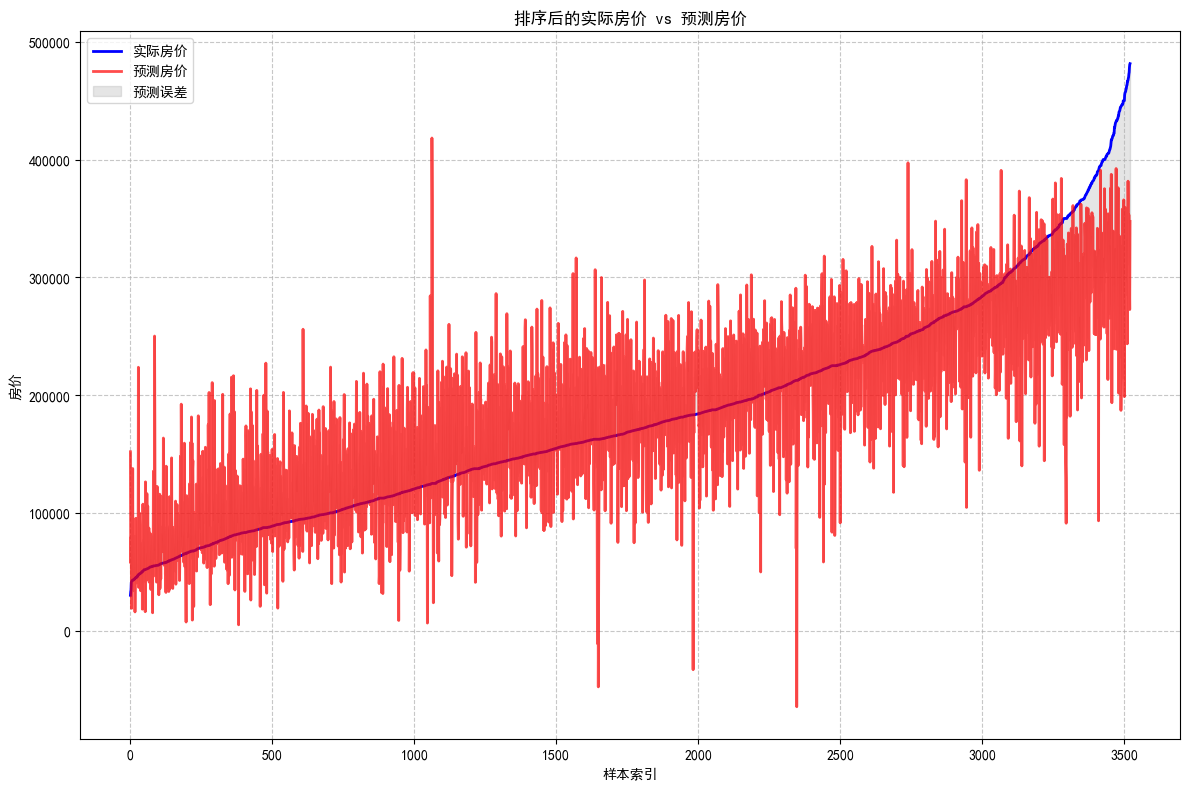

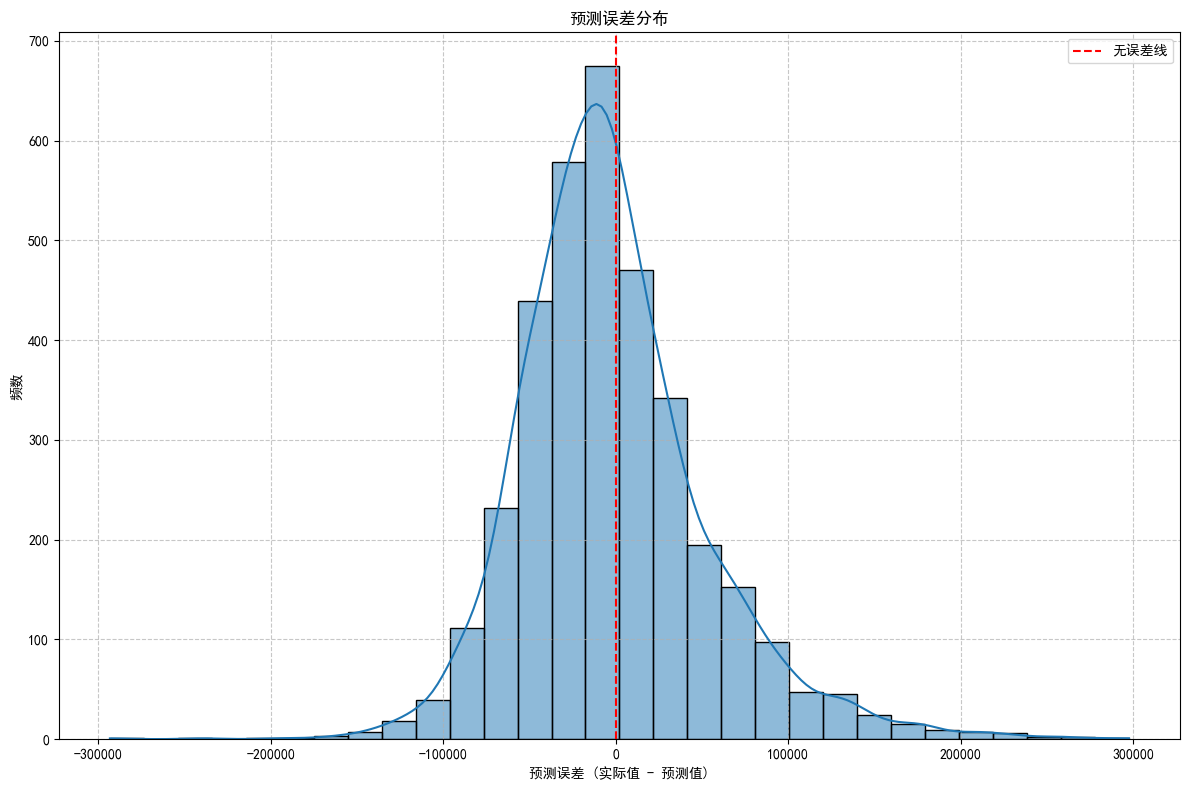

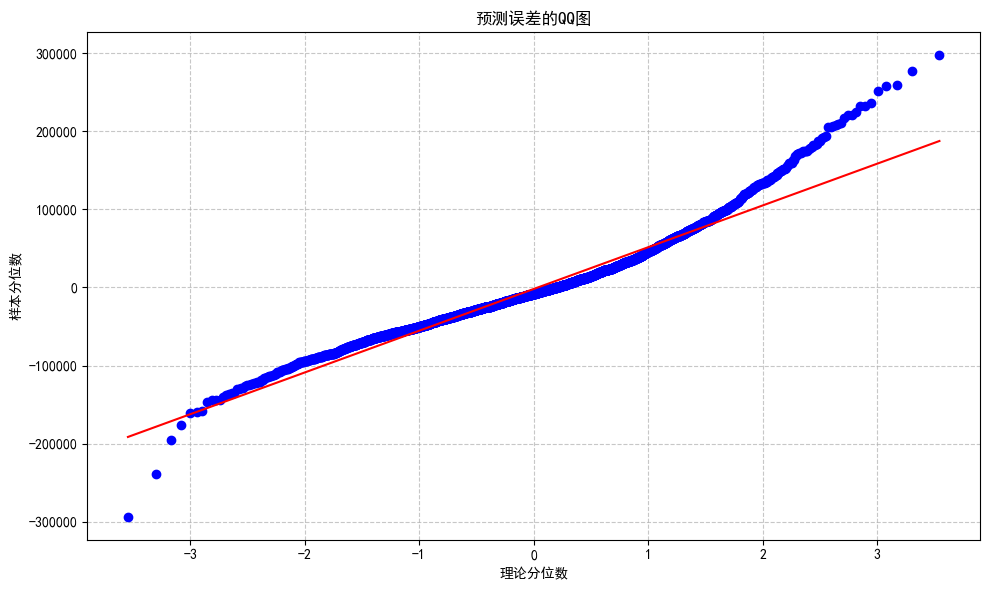

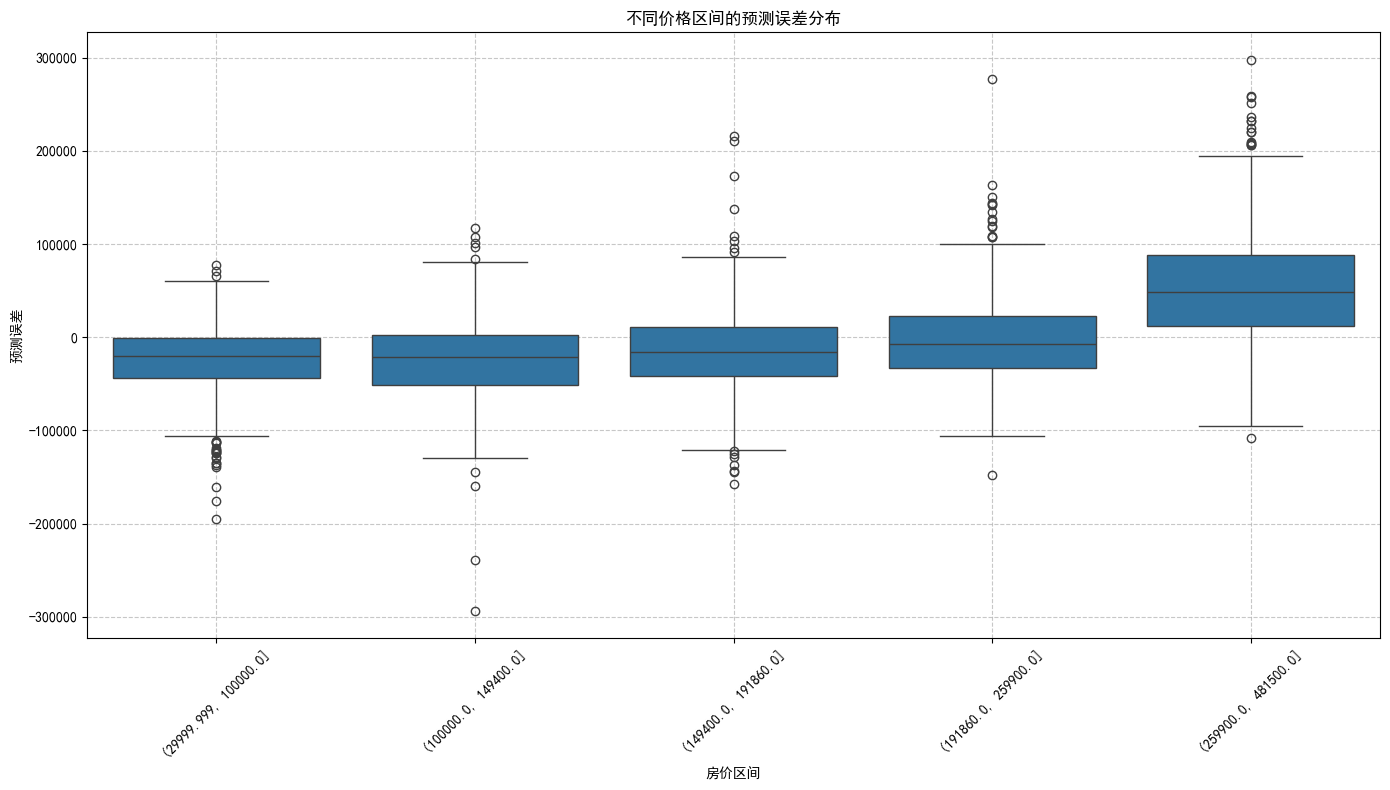

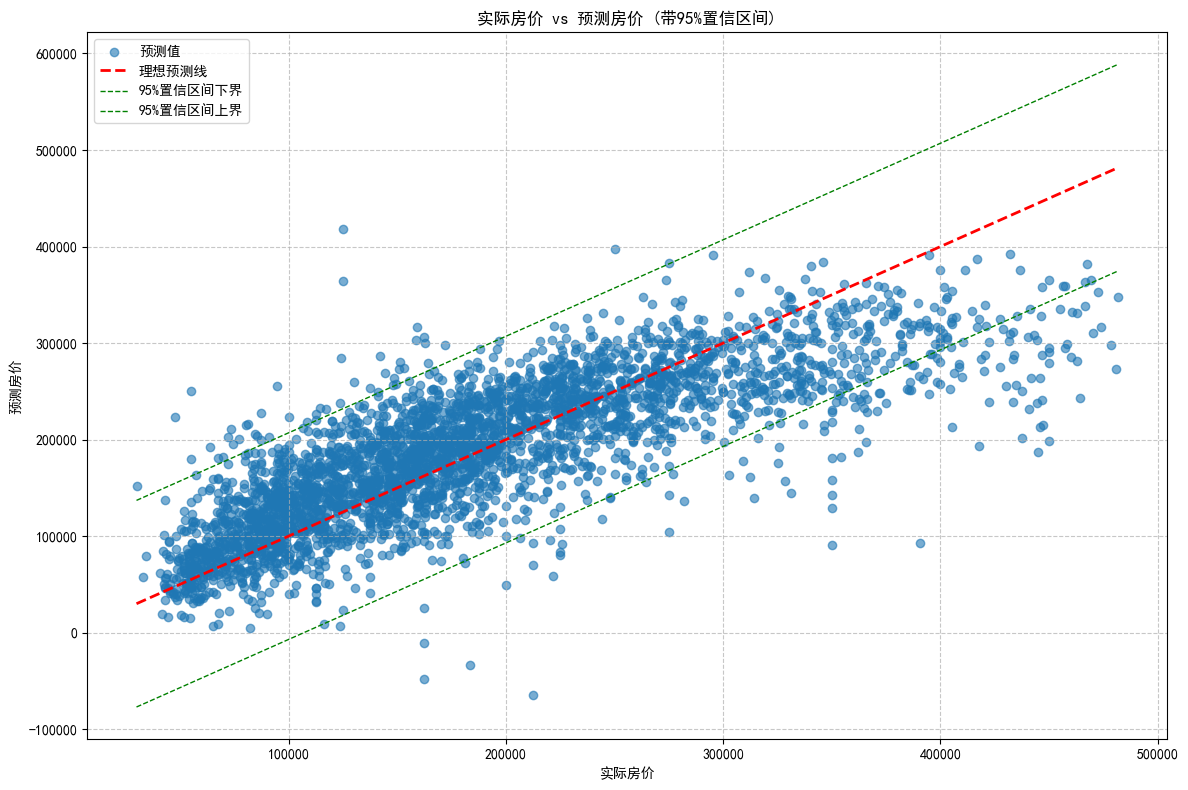

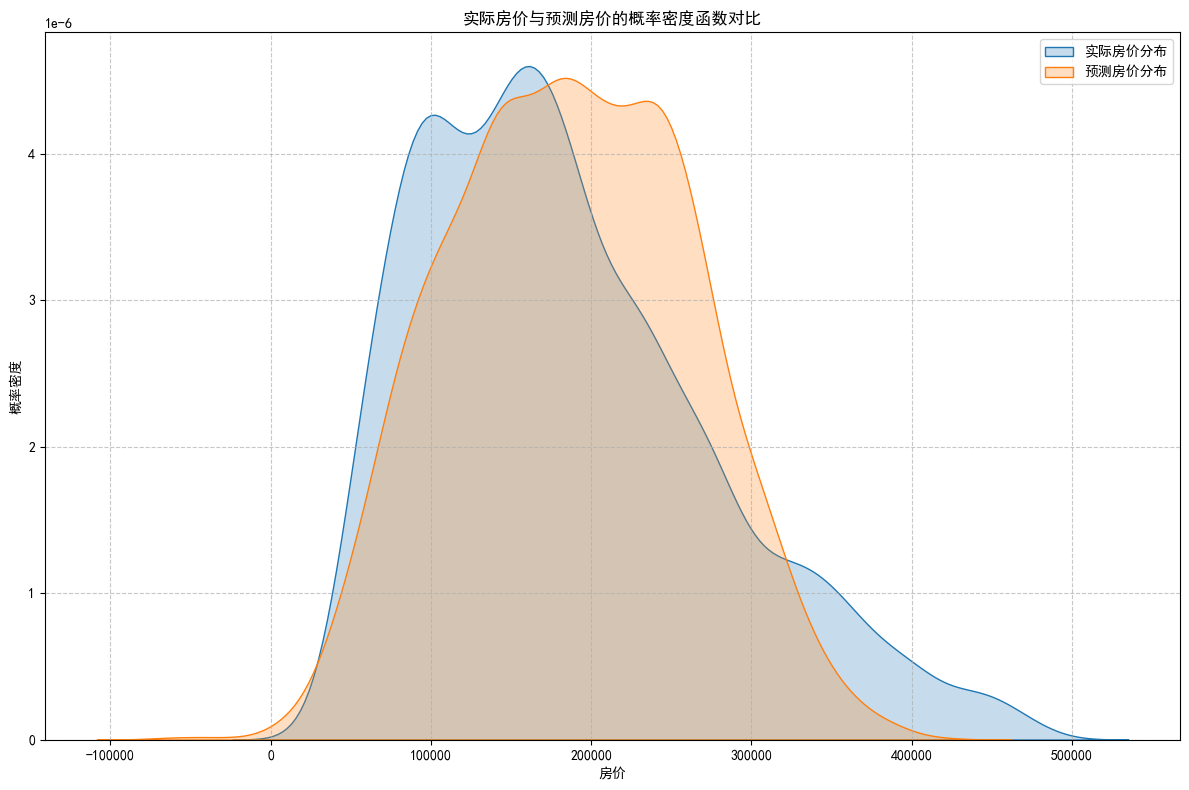

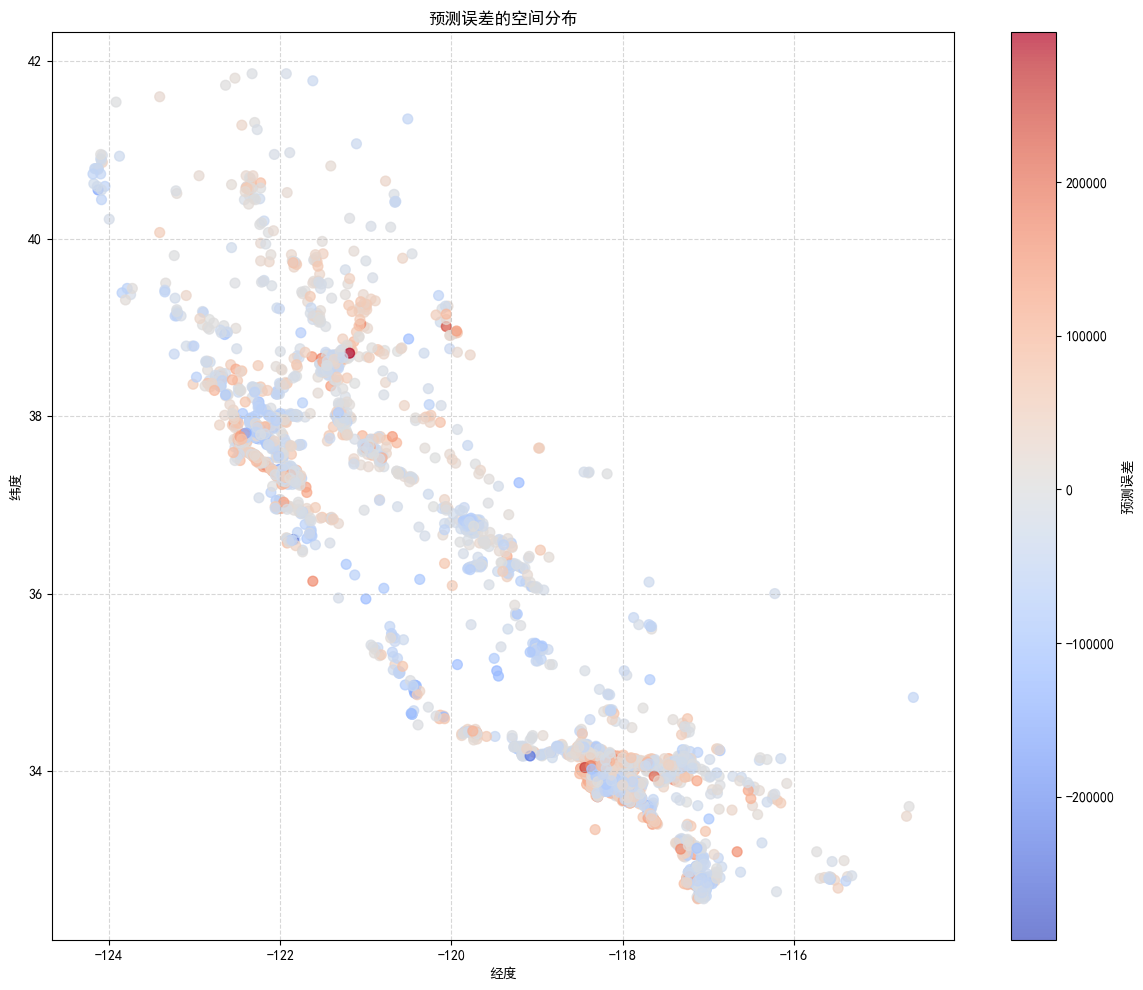

In [29]:
# ================== 8. 模型性能可视化对比 ==================
print("\n=== 模型性能可视化对比 ===")

# 复制结果数据
visualization_df = results_df.copy()

# 准备绘图数据
metrics = ['R²', '调整R²', 'RMSE', 'MAE', '交叉验证R²均值']
models = visualization_df['模型'].tolist()

# 创建一个大图表
plt.subplots_adjust(wspace=0.3)

# 1. 绘制模型性能对比柱状图
bar_width = 0.15
index = np.arange(len(models))

for i, metric in enumerate(metrics[:4]):  # 只显示前4个指标
    axes[0].bar(index + i * bar_width, visualization_df[metric], bar_width, label=metric)

# 设置图表属性
axes[0].set_xlabel('模型')
axes[0].set_ylabel('指标值')
axes[0].set_title('各模型性能指标对比')
axes[0].set_xticks(index + bar_width * 1.5)
axes[0].set_xticklabels(models, rotation=45, ha='right')
axes[0].legend(loc='best')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# 添加数值标签
def add_labels(ax, data, offset, width):
    for i, value in enumerate(data):
        ax.text(i + offset, value, f'{value:.3f}', ha='center', va='bottom', fontsize=8)

for i, metric in enumerate(metrics[:4]):
    add_labels(axes[0], visualization_df[metric], i * bar_width, bar_width)

# 2. 绘制最佳模型预测结果散点图
best_model_name = visualization_df.loc[visualization_df['RMSE'].idxmin(), '模型']
best_model = best_models.get(best_model_name, linear_model)  # 如果找不到，使用线性模型

# 在测试集上预测
# 确保X_test_df与训练时特征一致
X_test_processed = X_test_df
y_pred = best_model.predict(X_test_processed)

# 新增部分：将实际房价和预测房价按升序排序
# 3.1 按升序排序实际房价和对应的预测值
sorted_indices = np.argsort(y_test)
y_test_sorted = y_test.iloc[sorted_indices].values
y_pred_sorted = y_pred[sorted_indices]

# 绘制排序后的实际房价和预测房价对比图
plt.figure(figsize=(12, 8))
plt.plot(y_test_sorted, label='实际房价', color='blue', linewidth=2)
plt.plot(y_pred_sorted, label='预测房价', color='red', linewidth=2, alpha=0.7)
plt.fill_between(range(len(y_test_sorted)), y_test_sorted, y_pred_sorted, 
                 color='gray', alpha=0.2, label='预测误差')
plt.title('排序后的实际房价 vs 预测房价')
plt.xlabel('样本索引')
plt.ylabel('房价')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 3.2 绘制预测误差分布直方图（增强版）
plt.figure(figsize=(12, 8))
sns.histplot(y_test - y_pred, kde=True, bins=30)
plt.axvline(x=0, color='red', linestyle='--', label='无误差线')
plt.title('预测误差分布')
plt.xlabel('预测误差 (实际值 - 预测值)')
plt.ylabel('频数')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 3.3 绘制预测误差的QQ图，检验是否符合正态分布
plt.figure(figsize=(10, 6))
stats.probplot(y_test - y_pred, dist="norm", plot=plt)
plt.title('预测误差的QQ图')
plt.xlabel('理论分位数')
plt.ylabel('样本分位数')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 3.4 绘制不同价格区间的预测误差箱线图
# 创建价格区间
price_bins = pd.qcut(y_test, q=5)
plt.figure(figsize=(14, 8))
sns.boxplot(x=price_bins, y=y_test - y_pred)
plt.title('不同价格区间的预测误差分布')
plt.xlabel('房价区间')
plt.ylabel('预测误差')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 3.5 绘制预测置信区间（95%置信区间）
# 计算残差的标准差作为估计的误差
residuals = y_test - y_pred
residual_std = np.std(residuals)

# 计算95%置信区间（±1.96*标准差）
plt.figure(figsize=(12, 8))
plt.scatter(y_test, y_pred, alpha=0.6, label='预测值')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='理想预测线')

# 绘制置信区间边界
plt.plot([y_test.min(), y_test.max()], [y_test.min()-1.96*residual_std, y_test.max()-1.96*residual_std], 
         'g--', lw=1, label='95%置信区间下界')
plt.plot([y_test.min(), y_test.max()], [y_test.min()+1.96*residual_std, y_test.max()+1.96*residual_std], 
         'g--', lw=1, label='95%置信区间上界')

plt.title('实际房价 vs 预测房价 (带95%置信区间)')
plt.xlabel('实际房价')
plt.ylabel('预测房价')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 3.6 绘制预测房价的概率密度函数对比
plt.figure(figsize=(12, 8))
sns.kdeplot(y_test, label='实际房价分布', shade=True)
sns.kdeplot(y_pred, label='预测房价分布', shade=True)
plt.title('实际房价与预测房价的概率密度函数对比')
plt.xlabel('房价')
plt.ylabel('概率密度')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 3.7 绘制预测误差的空间分布（如果有地理信息）
# 假设我们有经纬度信息
plt.figure(figsize=(12, 10))
plt.scatter(X_test['longitude'], X_test['latitude'], c=y_test - y_pred, 
            cmap='coolwarm', s=50, alpha=0.7)
plt.colorbar(label='预测误差')
plt.title('预测误差的空间分布')
plt.xlabel('经度')
plt.ylabel('纬度')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [7]:
# ================== 9. 模型优化（添加多项式特征） ==================
print("\n=== 训练多项式模型 ===")

# 9.1 创建多项式特征
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_df)
X_test_poly = poly.transform(X_test_df)

print(f"多项式特征将特征数量从{X_train_df.shape[1]}扩展到{X_train_poly.shape[1]}")

# 9.2 标准化多项式特征
poly_scaler = StandardScaler()
X_train_poly_scaled = poly_scaler.fit_transform(X_train_poly)
X_test_poly_scaled = poly_scaler.transform(X_test_poly)

# 9.3 训练带多项式特征的Ridge回归（多项式特征容易过拟合，适合Ridge）
poly_ridge = Ridge(alpha=10.0)  # 使用较大的alpha防止过拟合
poly_results = evaluate_model(poly_ridge, X_train_poly_scaled, X_test_poly_scaled, y_train, y_test)

print("\n=== 多项式模型性能 ===")
print(pd.DataFrame([{'模型': '二阶多项式Ridge回归', **poly_results}]))

# 保存多项式模型
save_trained_models({'二阶多项式Ridge回归': poly_ridge})

# 将多项式模型结果添加到对比中，使用ignore_index重置索引
results_df = pd.concat([results_df, pd.DataFrame([{'模型': '二阶多项式Ridge回归', **poly_results}])], ignore_index=True)


=== 训练多项式模型 ===
多项式特征将特征数量从24扩展到324

=== 多项式模型性能 ===
             模型        R²      调整R²           MSE          RMSE           MAE  \
0  二阶多项式Ridge回归  0.708323  0.678764  2.460529e+09  49603.717142  35588.287591   

   交叉验证R²均值  交叉验证R²标准差  
0   0.69589   0.008736  
二阶多项式Ridge回归模型已保存到: saved_models\二阶多项式Ridge回归_model.pkl



=== 关键结论 ===
1. 正则化模型对比:
   - LASSO回归选择了22个重要特征，忽略了2个特征
   - 最重要的正向特征: latitude (77903.6744)
   - 最重要的负向特征: longitude (-270725.6911)

2. 最佳模型:
   - 二阶多项式Ridge回归表现最佳，RMSE为49603.72
   - 即模型预测的房价与实际房价平均相差约$49604

=== 特征重要性可视化 ===


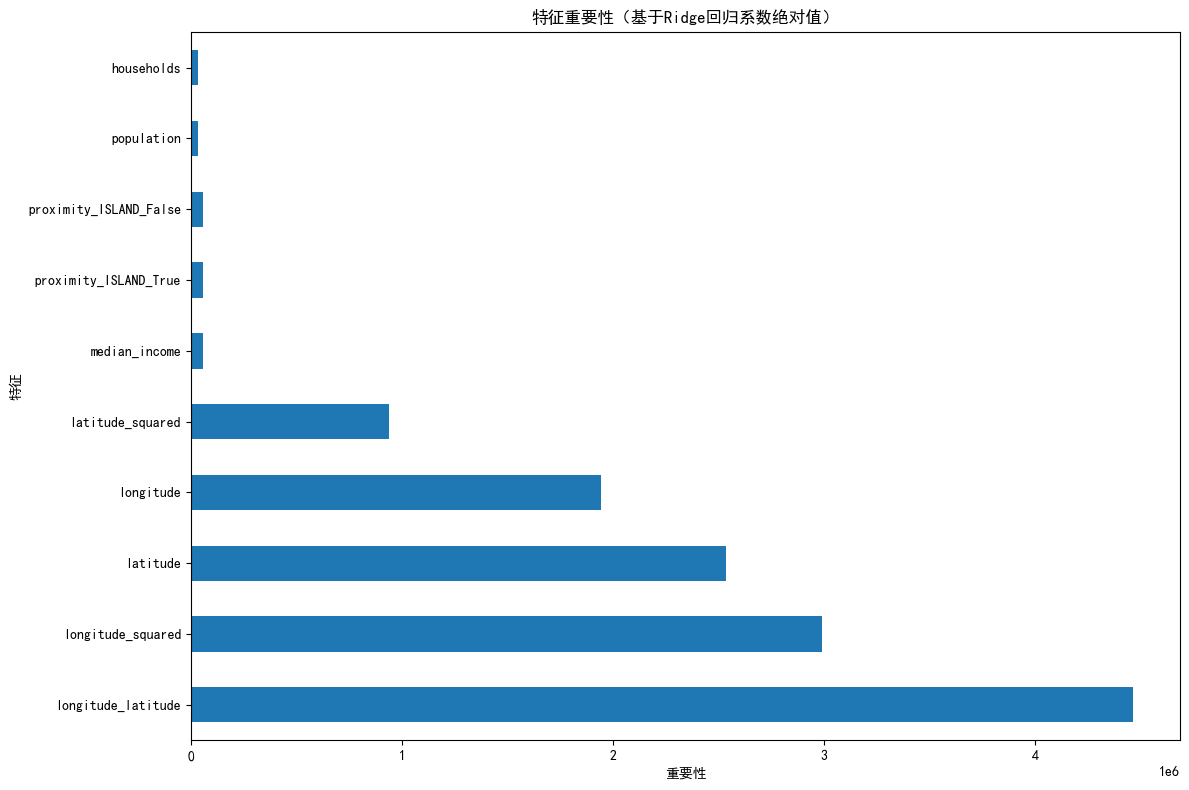

In [8]:
# ================== 10. 结果解释 ==================
print("\n=== 关键结论 ===")

# 提取LASSO模型系数（LASSO更适合特征选择）
lasso_model = best_models['Lasso']
coefs = pd.Series(lasso_model.coef_, index=feature_names)

# 计算特征重要性（绝对值）
importance = np.abs(coefs)
important_features = importance[importance > 0].sort_values(ascending=False)

# 找出最重要的正负向特征
top_positive_feature = coefs.idxmax()
top_negative_feature = coefs.idxmin()

print("1. 正则化模型对比:")
print(f"   - LASSO回归选择了{len(important_features)}个重要特征，忽略了{len(feature_names)-len(important_features)}个特征")
print(f"   - 最重要的正向特征: {top_positive_feature} ({coefs[top_positive_feature]:.4f})")
print(f"   - 最重要的负向特征: {top_negative_feature} ({coefs[top_negative_feature]:.4f})")

# 计算各模型的RMSE
results_df['RMSE'] = np.sqrt(results_df['MSE'])

# 确保min_rmse_idx是单个索引值
min_rmse_idx = results_df['RMSE'].idxmin()
best_model = results_df.loc[min_rmse_idx]  # 正确获取单行Series

print("\n2. 最佳模型:")
rmse_value = best_model['RMSE']  # 直接获取浮点数，无需转换
print(f"   - {best_model['模型']}表现最佳，RMSE为{rmse_value:.2f}")
print(f"   - 即模型预测的房价与实际房价平均相差约${rmse_value:.0f}")

# ================== 11. 特征重要性可视化 ==================
print("\n=== 特征重要性可视化 ===")

# 提取Ridge模型系数（Ridge更稳定，适合解释特征重要性）
ridge_model = best_models['Ridge']
ridge_coefs = pd.Series(ridge_model.coef_, index=feature_names)

# 计算特征重要性（绝对值）
ridge_importance = np.abs(ridge_coefs)
top_features = ridge_importance.sort_values(ascending=False).head(10)

# 绘制特征重要性条形图
plt.figure(figsize=(12, 8))
top_features.plot(kind='barh')
plt.title('特征重要性（基于Ridge回归系数绝对值）')
plt.xlabel('重要性')
plt.ylabel('特征')
plt.tight_layout()
plt.show()


In [9]:
# ================== 12. 模型使用示例 ==================
print("\n=== 模型使用示例 ===")

# 保存预处理对象，用于后续预测
preprocessing_objects = {
    'encoder': encoder,
    'scaler': scaler,
    'poly': poly,
    'poly_scaler': poly_scaler,
    'categorical_features': categorical_features,
    'numerical_features': numerical_features,
    'feature_names': feature_names
}

joblib.dump(preprocessing_objects, 'saved_models/preprocessing_objects.pkl')
print("预处理对象已保存到 saved_models/preprocessing_objects.pkl")

# 加载保存的最佳模型和预处理对象
model_to_use = best_model['模型']
loaded_model = load_saved_model(model_to_use)
preprocessing = joblib.load('saved_models/preprocessing_objects.pkl')

if loaded_model and preprocessing:
    # 随机选择一个样本进行预测演示
    sample_idx = np.random.randint(0, len(X_test))
    sample = X_test.iloc[sample_idx:sample_idx+1]
    actual_value = y_test.iloc[sample_idx]
    
    # 预处理样本
    sample_cat = preprocessing['encoder'].transform(sample[preprocessing['categorical_features']])
    sample_num = preprocessing['scaler'].transform(sample[preprocessing['numerical_features']])
    sample_processed = np.hstack([sample_num, sample_cat])
    
    # 转换为DataFrame
    sample_df = pd.DataFrame(sample_processed, columns=preprocessing['feature_names'])
    
    # 如果是多项式模型，还需要进行多项式转换和标准化
    if model_to_use == '二阶多项式Ridge回归':
        sample_poly = preprocessing['poly'].transform(sample_df)
        sample_poly_scaled = preprocessing['poly_scaler'].transform(sample_poly)
        sample_for_prediction = sample_poly_scaled
    else:
        sample_for_prediction = sample_df
    
    # 进行预测
    predicted_value = loaded_model.predict(sample_for_prediction)[0]
    
    print(f"\n示例预测:")
    print(f"样本原始特征: {sample.to_dict('records')[0]}")
    print(f"实际房价: ${actual_value:.2f}")
    print(f"预测房价: ${predicted_value:.2f}")
    print(f"预测误差: ${actual_value - predicted_value:.2f} ({((actual_value - predicted_value) / actual_value) * 100:.2f}%)")


=== 模型使用示例 ===
预处理对象已保存到 saved_models/preprocessing_objects.pkl
已加载二阶多项式Ridge回归模型

示例预测:
样本原始特征: {'longitude': -118.31, 'latitude': 33.93, 'housing_median_age': 37.0, 'total_rooms': 1282.0, 'total_bedrooms': 244.0, 'population': 852.0, 'households': 249.0, 'median_income': 4.2917, 'proximity_<1H OCEAN': True, 'proximity_INLAND': False, 'proximity_ISLAND': False, 'proximity_NEAR BAY': False, 'proximity_NEAR OCEAN': False, 'rooms_per_household': 5.14859437751004, 'bedrooms_per_room': 0.19032761310452417, 'population_per_household': 3.4216867469879517, 'longitude_squared': 13997.2561, 'latitude_squared': 1151.2449, 'longitude_latitude': -4014.2583}
实际房价: $127900.00
预测房价: $210985.10
预测误差: $-83085.10 (-64.96%)



=== Lasso模型解释 ===

Lasso模型公式:
y = 295129.4880 + 149042.4308*longitude - 140618.1373*latitude - 134542.7415*housing_median_age + 40039.6046*total_rooms + 38854.0368*total_bedrooms + 35926.6908*population + 9007.8021*households - 2018.8037*median_income + 1480.8423*rooms_per_household - 1079.4660*bedrooms_per_room + 850.0031*population_per_household - 722.3986*longitude_squared - 466.7377*latitude_squared + 156.1993*longitude_latitude + 60.0194*proximity_<1H OCEAN_False - 59.6821*proximity_<1H OCEAN_True + 32.9680*proximity_INLAND_False - 5.2395*proximity_INLAND_True + 0.0000*proximity_ISLAND_False - 0.0000*proximity_ISLAND_True - 0.0000*proximity_NEAR BAY_False + 0.0000*proximity_NEAR BAY_True


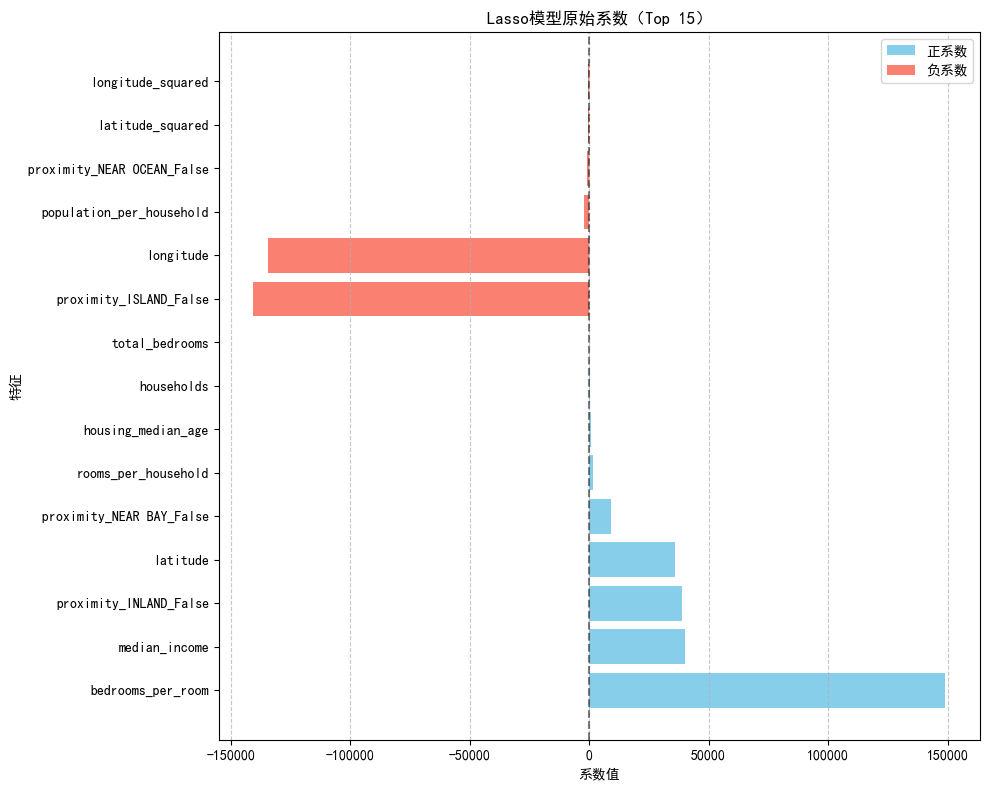

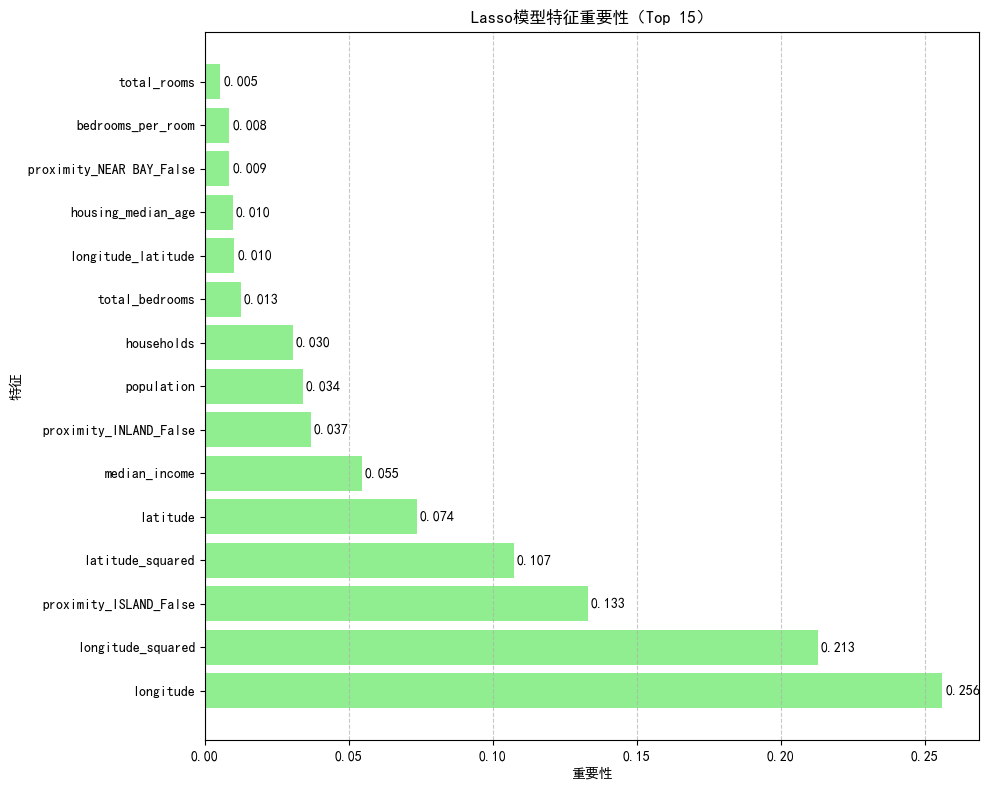

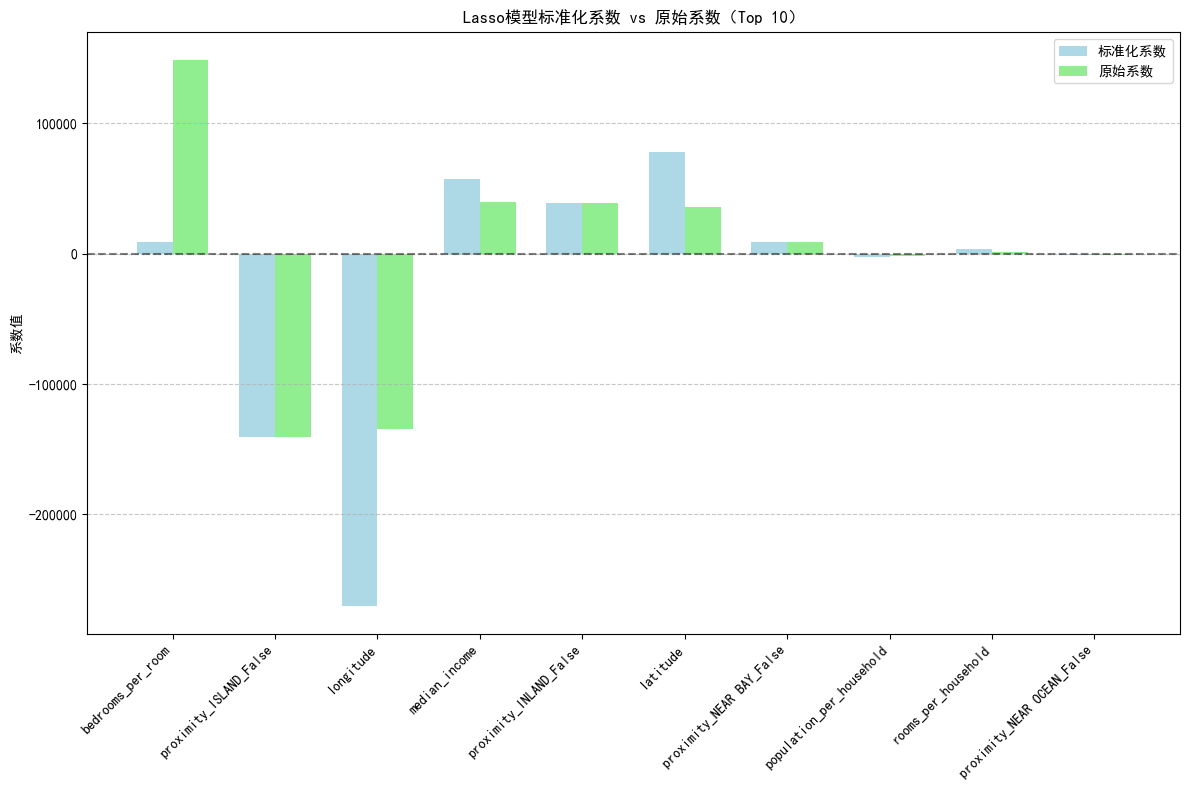


=== Ridge模型解释 ===

Ridge模型公式:
y = 216950.7282 + 1169352.6036*longitude + 965234.7747*latitude + 147072.4095*housing_median_age + 56839.9139*total_rooms - 56839.9139*total_bedrooms + 39989.9728*population + 24498.5503*households - 24498.5491*median_income + 13607.3160*rooms_per_household + 12641.5688*bedrooms_per_room - 12641.5688*population_per_household + 10877.4457*longitude_squared - 10877.4453*latitude_squared - 8822.3559*longitude_latitude + 8822.3559*proximity_<1H OCEAN_False + 6197.2242*proximity_<1H OCEAN_True + 5993.1110*proximity_INLAND_False - 1862.3740*proximity_INLAND_True + 1110.4094*proximity_ISLAND_False + 865.1859*proximity_ISLAND_True + 166.8362*proximity_NEAR BAY_False - 59.4032*proximity_NEAR BAY_True + 48.0289*proximity_NEAR OCEAN_False - 4.8099*proximity_NEAR OCEAN_True


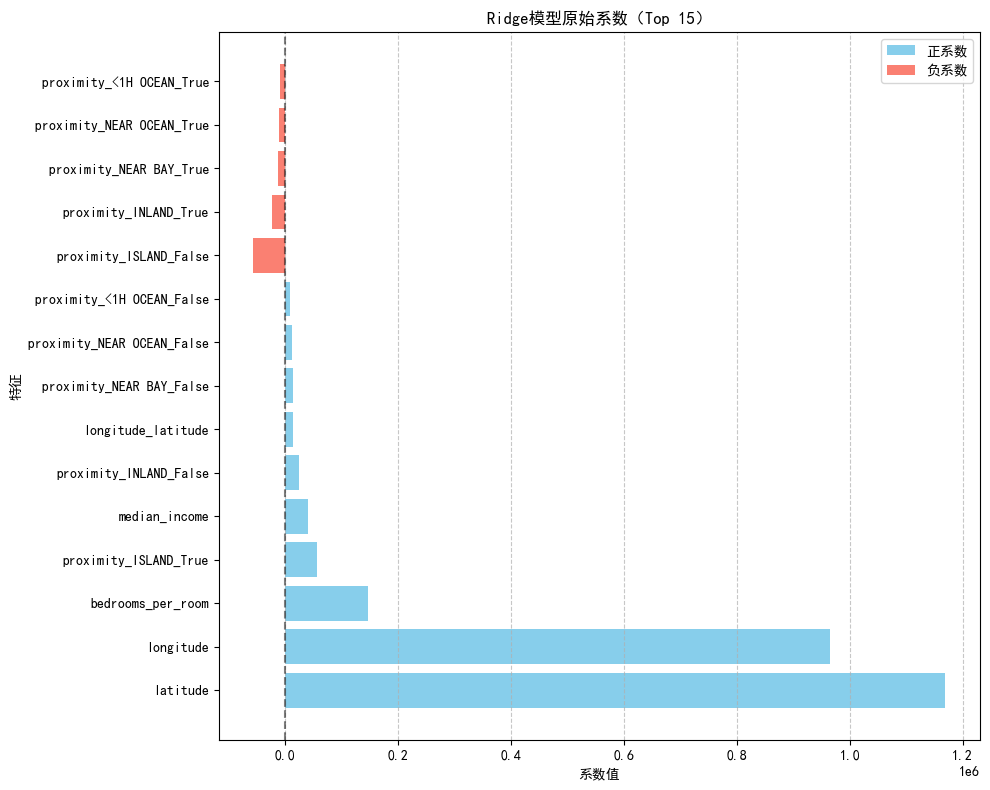

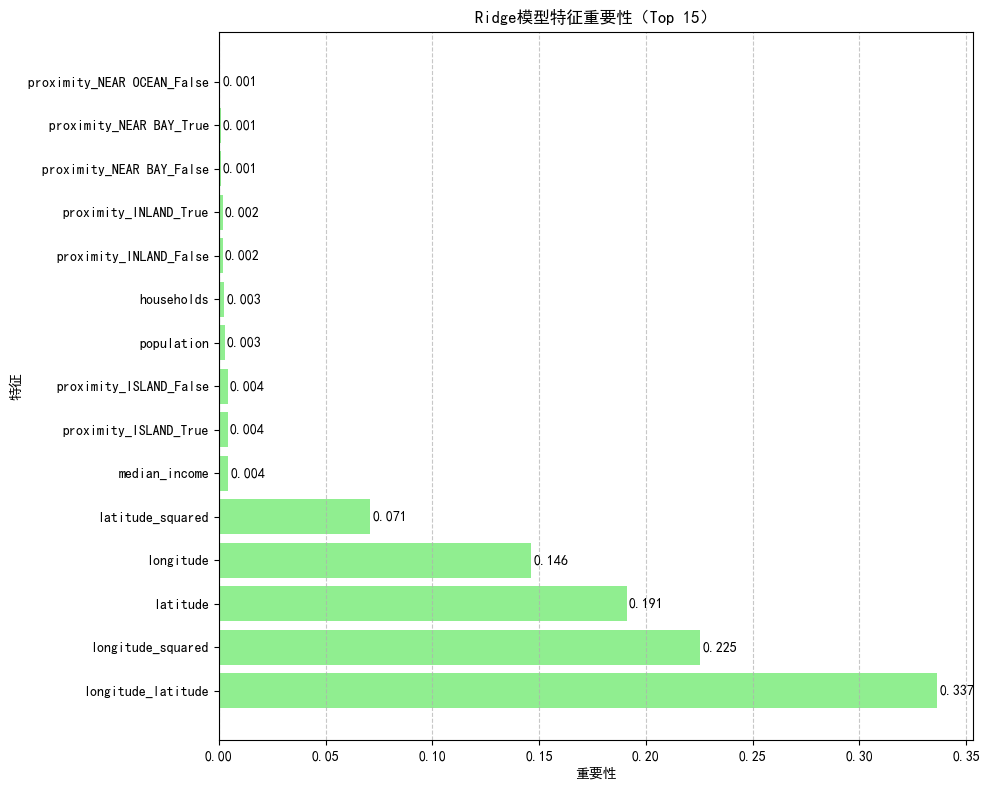

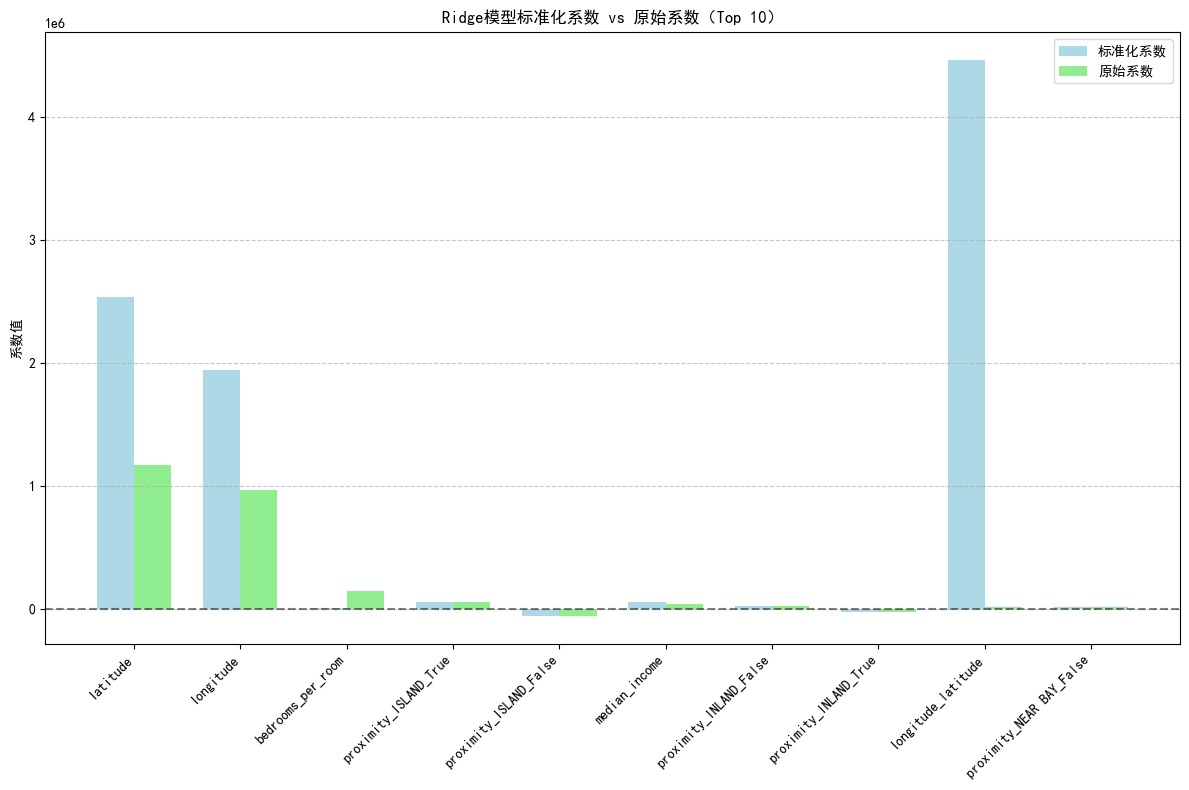


=== 线性回归模型解释 ===

线性回归模型公式:
y = 216695.7737 + 1244988.8838*longitude + 1053987.1295*latitude + 147060.4073*housing_median_age - 56569.6483*total_rooms + 56569.6483*total_bedrooms + 39997.5637*population - 24151.7670*households + 24151.7670*median_income + 14500.9477*rooms_per_household - 12629.4101*bedrooms_per_room + 12629.4101*population_per_household + 11038.2013*longitude_squared - 11038.2013*latitude_squared - 8750.2698*longitude_latitude + 8750.2698*proximity_<1H OCEAN_False + 6704.2730*proximity_<1H OCEAN_True + 6420.7648*proximity_INLAND_False - 1851.1328*proximity_INLAND_True + 1090.0038*proximity_ISLAND_False + 867.5486*proximity_ISLAND_True + 167.8187*proximity_NEAR BAY_False - 59.3682*proximity_NEAR BAY_True + 47.1325*proximity_NEAR OCEAN_False - 4.8201*proximity_NEAR OCEAN_True


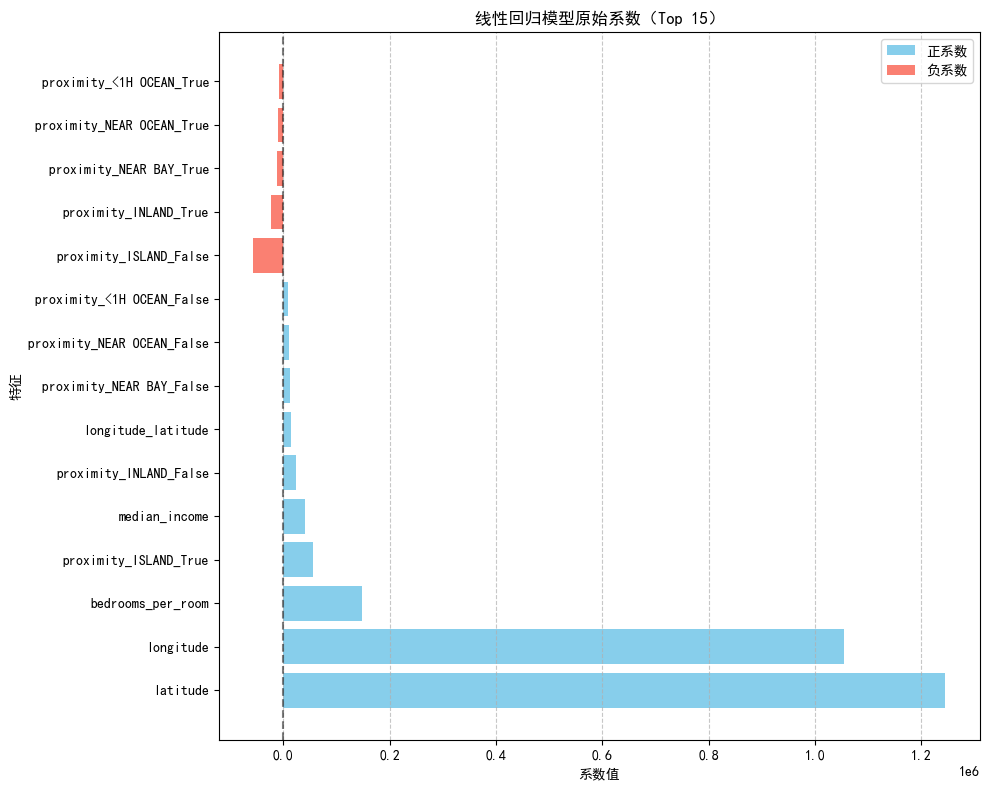

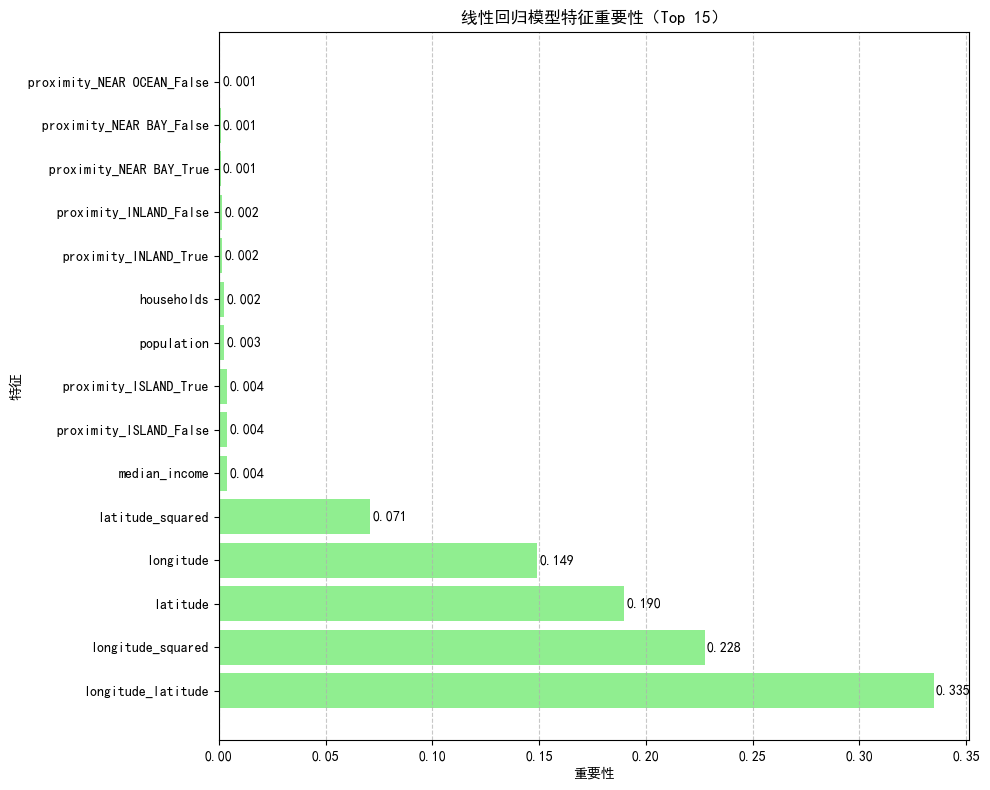

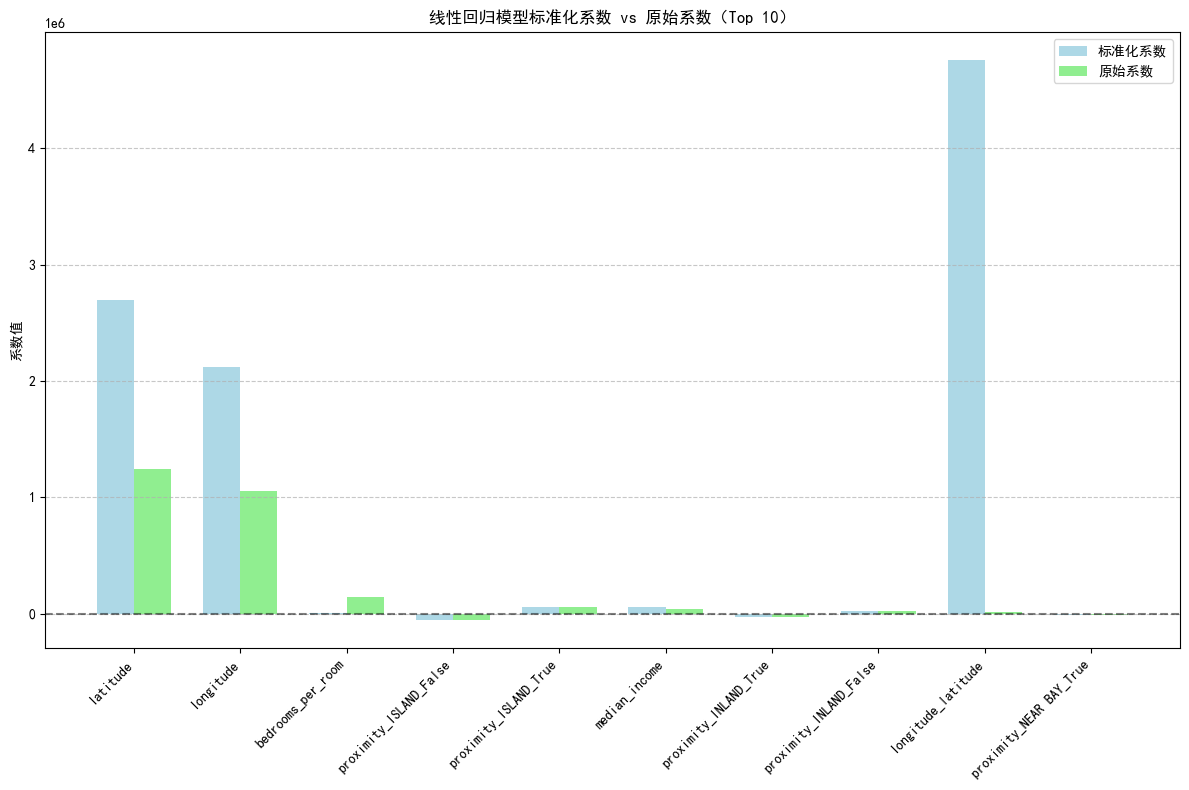


模型解释结果已保存至 saved_models/model_explanations.pkl


In [21]:
# ================== 模型系数解释与可视化 ==================

# 计算原始尺度下的系数
def get_original_coefficients(model, scaler, feature_names, categorical_features, numerical_features):
    """计算包含标准化和未标准化特征的原始系数"""
    std_coef = model.coef_
    
    # 创建完整的缩放因子数组（对应所有特征）
    full_scales = np.ones(len(feature_names))  # 初始化为1（未标准化的特征）
    
    # 找到数值特征在完整特征列表中的索引位置
    num_indices = [feature_names.index(f) for f in numerical_features if f in feature_names]
    
    # 将数值特征对应的缩放因子设置为实际的标准差
    full_scales[num_indices] = scaler.scale_
    
    # 计算原始系数
    original_coef = std_coef / full_scales
    
    coef_df = pd.DataFrame({
        '特征': feature_names,
        '标准化系数': std_coef,
        '原始系数': original_coef,
        '系数绝对值': np.abs(original_coef)
    })
    
    coef_df = coef_df.sort_values('系数绝对值', ascending=False)
    return coef_df

# 计算特征重要性
def calculate_feature_importance(model, feature_names):
    """计算线性模型的特征重要性"""
    if hasattr(model, 'coef_'):
        importance = np.abs(model.coef_)
        importance = importance / importance.sum()  # 归一化
    else:
        raise ValueError("模型没有coef_属性")
    
    importance_df = pd.DataFrame({
        '特征': feature_names,
        '重要性': importance
    })
    
    return importance_df.sort_values('重要性', ascending=False)

# 构建线性回归模型公式
def build_model_formula(model, feature_names, original_coef=None):
    """构建模型公式，可选择使用原始系数或标准化系数"""
    formula = "y = " + f"{model.intercept_:.4f}"
    coefs = original_coef if original_coef is not None else model.coef_
    
    for i, coef in enumerate(coefs):
        if coef != 0:
            # 格式化系数，保留4位小数
            coef_str = f"{coef:.4f}"
            
            # 根据系数正负调整符号
            if coef > 0:
                formula += f" + {coef_str}*{feature_names[i]}"
            else:
                formula += f" - {abs(coef):.4f}*{feature_names[i]}"
    
    return formula

# 可视化模型系数
def plot_coefficients(coef_df, model_name, top_n=15, figsize=(10, 8)):
    """可视化模型系数"""
    # 按系数绝对值排序
    coef_df = coef_df.sort_values('系数绝对值', ascending=False).head(top_n)
    
    # 区分正负系数
    positive = coef_df[coef_df['原始系数'] > 0]
    negative = coef_df[coef_df['原始系数'] <= 0]
    
    plt.figure(figsize=figsize)
    
    # 绘制正系数
    if not positive.empty:
        plt.barh(positive['特征'], positive['原始系数'], color='skyblue', label='正系数')
    
    # 绘制负系数
    if not negative.empty:
        plt.barh(negative['特征'], negative['原始系数'], color='salmon', label='负系数')
    
    plt.axvline(x=0, color='black', linestyle='--', alpha=0.5)
    plt.title(f'{model_name}模型原始系数（Top {top_n}）')
    plt.xlabel('系数值')
    plt.ylabel('特征')
    plt.legend()
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# 可视化特征重要性
def plot_feature_importance(importance_df, model_name, top_n=15, figsize=(10, 8)):
    """可视化特征重要性"""
    # 按重要性排序
    importance_df = importance_df.sort_values('重要性', ascending=False).head(top_n)
    
    plt.figure(figsize=figsize)
    plt.barh(importance_df['特征'], importance_df['重要性'], color='lightgreen')
    
    # 添加数值标签
    for i, v in enumerate(importance_df['重要性']):
        plt.text(v + 0.001, i, f'{v:.3f}', va='center')
    
    plt.title(f'{model_name}模型特征重要性（Top {top_n}）')
    plt.xlabel('重要性')
    plt.ylabel('特征')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# 可视化标准化系数与原始系数对比
def compare_standardized_original_coefficients(coef_df, model_name, top_n=10, figsize=(12, 8)):
    """比较标准化系数和原始系数"""
    # 按原始系数绝对值排序
    coef_df = coef_df.sort_values('系数绝对值', ascending=False).head(top_n)
    
    x = np.arange(len(coef_df['特征']))
    width = 0.35
    
    plt.figure(figsize=figsize)
    plt.bar(x - width/2, coef_df['标准化系数'], width, label='标准化系数', color='lightblue')
    plt.bar(x + width/2, coef_df['原始系数'], width, label='原始系数', color='lightgreen')
    
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    plt.xticks(x, coef_df['特征'], rotation=45, ha='right')
    plt.title(f'{model_name}模型标准化系数 vs 原始系数（Top {top_n}）')
    plt.ylabel('系数值')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# 获取并展示模型解释结果
def explain_model(model, model_name, scaler, feature_names, categorical_features, numerical_features):
    """获取并展示模型解释结果"""
    print(f"\n=== {model_name}模型解释 ===")
    
    # 获取原始系数
    original_coef = get_original_coefficients(
        model, scaler, feature_names, categorical_features, numerical_features
    )
    
    # 获取特征重要性
    importance = calculate_feature_importance(model, feature_names)
    
    # 打印原始系数
    # print(f"\n{model_name}模型原始系数（按重要性排序）:")
    # print(original_coef)
    
    # 打印特征重要性
    # print(f"\n{model_name}模型特征重要性:")
    # print(importance)
    
    # 构建并打印模型公式
    model_formula = build_model_formula(model, feature_names, original_coef['原始系数'])
    print(f"\n{model_name}模型公式:")
    print(model_formula)
    
    # 可视化原始系数
    plot_coefficients(original_coef, model_name)
    
    # 可视化特征重要性
    plot_feature_importance(importance, model_name)
    
    # 可视化系数对比
    compare_standardized_original_coefficients(original_coef, model_name)
    
    # 返回结果供后续使用
    return {
        'model': model,
        'original_coef': original_coef,
        'importance': importance,
        'formula': model_formula
    }

# 解释所有模型
lasso_results = explain_model(
    best_models['Lasso'], 'Lasso', 
    scaler, feature_names, categorical_features, numerical_features
)

ridge_results = explain_model(
    best_models['Ridge'], 'Ridge', 
    scaler, feature_names, categorical_features, numerical_features
)

linear_results = explain_model(
    linear_model, '线性回归', 
    scaler, feature_names, categorical_features, numerical_features
)

# 保存解释结果
results_to_save = {
    'lasso': lasso_results,
    'ridge': ridge_results,
    'linear': linear_results
}

joblib.dump(results_to_save, 'saved_models/model_explanations.pkl')
print("\n模型解释结果已保存至 saved_models/model_explanations.pkl")